In [1]:
import os
import cv2
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
random.seed(10)

IMAGE_SIZE = 48
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("../input/fer-lol/low_res/our/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("../input/fer-lol/low_res/our/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("../input/fer-lol/low_res/eval/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("../input/fer-lol/low_res/eval/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("../input/fer-lol/low_res/eval/low/*"))
test_enhanced_images = sorted(glob("../input/fer-lol/low_res/eval/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

2022-08-03 04:13:33.408889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 04:13:33.546043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 04:13:33.546860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 04:13:33.556141: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Train Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>


In [3]:
def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

In [4]:
def spatial_attention_block(input_tensor):
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = layers.Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])

In [5]:
# Recursive Residual Modules


def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau), level2_dau, up_sampling_module(level3_dau)
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level3_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])

In [6]:
def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=64)

# Training

2022-08-03 04:13:43.573999: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-03 04:14:21.816805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


75/75 [==============================] - 71s 361ms/step - loss: 0.1024 - peak_signal_noise_ratio: 66.1893 - val_loss: 0.0515 - val_peak_signal_noise_ratio: 69.2920
Epoch 2/50
75/75 [==============================] - 24s 315ms/step - loss: 0.0417 - peak_signal_noise_ratio: 70.7510 - val_loss: 0.0332 - val_peak_signal_noise_ratio: 72.7212
Epoch 3/50
75/75 [==============================] - 21s 282ms/step - loss: 0.0302 - peak_signal_noise_ratio: 74.4333 - val_loss: 0.0269 - val_peak_signal_noise_ratio: 76.0987
Epoch 4/50
75/75 [==============================] - 20s 270ms/step - loss: 0.0241 - peak_signal_noise_ratio: 77.1434 - val_loss: 0.0214 - val_peak_signal_noise_ratio: 78.1673
Epoch 5/50
75/75 [==============================] - 21s 275ms/step - loss: 0.0205 - peak_signal_noise_ratio: 78.6857 - val_loss: 0.0196 - val_peak_signal_noise_ratio: 79.1159
Epoch 6/50
75/75 [==============================] - 23s 313ms/step - loss: 0.0191 - peak_signal_noise_ratio: 79.4286 - val_loss: 0.0187 

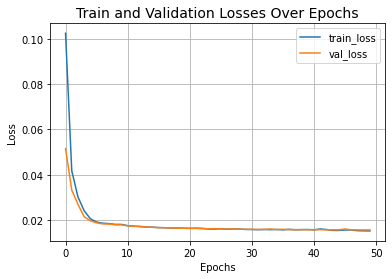

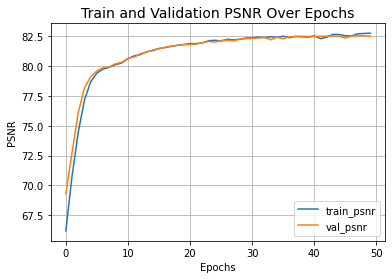

In [7]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [8]:
from tensorflow.keras import models, layers, regularizers

models.save_model(model,'./MIRNet.h5') 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [9]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output = model.predict(image)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    return output_image

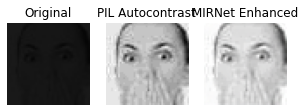

In [10]:
for low_light_image in random.sample(test_low_light_images, 1):
    original_image = Image.open(low_light_image)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
        (5, 8),
    )

# Hyperparameter

### learning rate 0.001, Adam Optimizer & patience = 10

In [11]:
from tensorflow.keras import models, layers, regularizers

model = models.load_model('../input/pretrained/MIRNet.h5', compile=False) 

In [12]:
random.seed(10)

IMAGE_SIZE = 48
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("../input/fer-lol/low_res/our/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("../input/fer-lol/low_res/our/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("../input/fer-lol/low_res/eval/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("../input/fer-lol/low_res/eval/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("../input/fer-lol/low_res/eval/low/*"))
test_enhanced_images = sorted(glob("../input/fer-lol/low_res/eval/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>


Epoch 1/50
75/75 [==============================] - 65s 350ms/step - loss: 0.1583 - peak_signal_noise_ratio: 66.5728 - val_loss: 0.0374 - val_peak_signal_noise_ratio: 73.5034
Epoch 2/50
75/75 [==============================] - 20s 270ms/step - loss: 0.0304 - peak_signal_noise_ratio: 76.2196 - val_loss: 0.0211 - val_peak_signal_noise_ratio: 79.4866
Epoch 3/50
75/75 [==============================] - 21s 277ms/step - loss: 0.0219 - peak_signal_noise_ratio: 79.4752 - val_loss: 0.0168 - val_peak_signal_noise_ratio: 81.3704
Epoch 4/50
75/75 [==============================] - 20s 274ms/step - loss: 0.0170 - peak_signal_noise_ratio: 81.3622 - val_loss: 0.0167 - val_peak_signal_noise_ratio: 81.5219
Epoch 5/50
75/75 [==============================] - 23s 310ms/step - loss: 0.0180 - peak_signal_noise_ratio: 80.9378 - val_loss: 0.0166 - val_peak_signal_noise_ratio: 81.7016
Epoch 6/50
75/75 [==============================] - 21s 276ms/step - loss: 0.0229 - peak_signal_noise_ratio: 79.4253 - val_lo

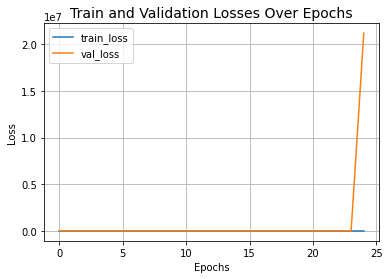

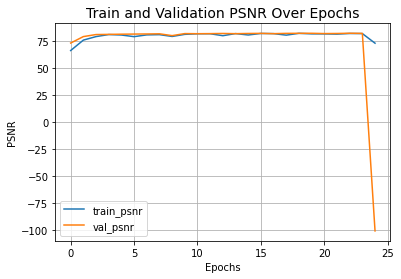

In [13]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=10,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [14]:
models.save_model(model,'./MIRNetH1.h5') 

# Hyperparameter 2

### learning rate 0.0001, SGD Optimizer & patience = 10

In [15]:
from tensorflow.keras import models, layers, regularizers

model = models.load_model('../input/pretrainedh1/MIRNetH1.h5', compile=False) 

In [16]:
random.seed(10)

IMAGE_SIZE = 48
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("../input/fer-lol/low_res/our/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("../input/fer-lol/low_res/our/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("../input/fer-lol/low_res/eval/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("../input/fer-lol/low_res/eval/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("../input/fer-lol/low_res/eval/low/*"))
test_enhanced_images = sorted(glob("../input/fer-lol/low_res/eval/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>


Epoch 1/50
75/75 [==============================] - 58s 334ms/step - loss: 0.0120 - peak_signal_noise_ratio: 84.2803 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8208
Epoch 2/50
75/75 [==============================] - 20s 268ms/step - loss: 0.0119 - peak_signal_noise_ratio: 84.2852 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8231
Epoch 3/50
75/75 [==============================] - 20s 262ms/step - loss: 0.0119 - peak_signal_noise_ratio: 84.2878 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8250
Epoch 4/50
75/75 [==============================] - 20s 268ms/step - loss: 0.0119 - peak_signal_noise_ratio: 84.2901 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8267
Epoch 5/50
75/75 [==============================] - 20s 272ms/step - loss: 0.0119 - peak_signal_noise_ratio: 84.2922 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8281
Epoch 6/50
75/75 [==============================] - 19s 260ms/step - loss: 0.0119 - peak_signal_noise_ratio: 84.2941 - val_lo

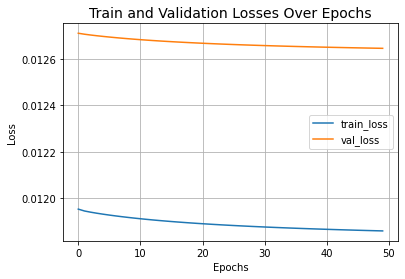

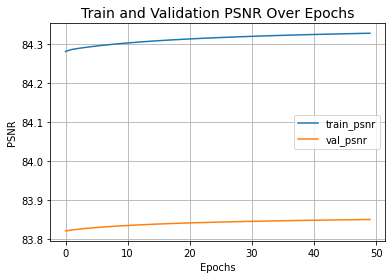

In [17]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.SGD(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=10,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [18]:
models.save_model(model,'./MIRNetH2.h5') 

# Hyperparameter 3

### learning rate 0.001, SGD Optimizer & patience = 10

In [19]:
random.seed(10)

IMAGE_SIZE = 48
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("../input/fer-lol/low_res/our/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("../input/fer-lol/low_res/our/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("../input/fer-lol/low_res/eval/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("../input/fer-lol/low_res/eval/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("../input/fer-lol/low_res/eval/low/*"))
test_enhanced_images = sorted(glob("../input/fer-lol/low_res/eval/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>


Epoch 1/50
75/75 [==============================] - 60s 378ms/step - loss: 0.0119 - peak_signal_noise_ratio: 84.3254 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8205
Epoch 2/50
75/75 [==============================] - 20s 270ms/step - loss: 0.0119 - peak_signal_noise_ratio: 84.3275 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8226
Epoch 3/50
75/75 [==============================] - 20s 263ms/step - loss: 0.0119 - peak_signal_noise_ratio: 84.3298 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8243
Epoch 4/50
75/75 [==============================] - 20s 263ms/step - loss: 0.0118 - peak_signal_noise_ratio: 84.3317 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8259
Epoch 5/50
75/75 [==============================] - 20s 267ms/step - loss: 0.0118 - peak_signal_noise_ratio: 84.3334 - val_loss: 0.0127 - val_peak_signal_noise_ratio: 83.8273
Epoch 6/50
75/75 [==============================] - 20s 265ms/step - loss: 0.0118 - peak_signal_noise_ratio: 84.3349 - val_lo

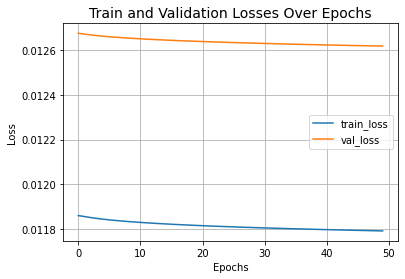

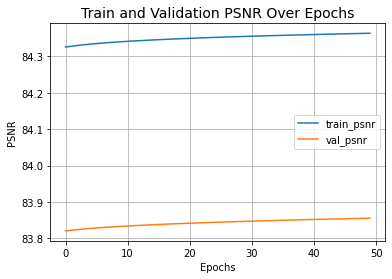

In [20]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=10,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [21]:
models.save_model(model,'./MIRNetH3.h5') 